In [883]:
# import zipfile
#
# with zipfile.ZipFile("data/skincancer.zip", 'r') as zip_ref:
#     zip_ref.extractall("data/")

In [884]:
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm


In [885]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [886]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img

# transform data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [887]:
# load test and training folders
train_dataset = ImageFolder(root='data/Skin_Data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/Skin_Data/test', transform=transform)

In [888]:
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# to verify it's working:
print("Classes:", train_dataset.classes)
print("Number of train images:", len(train_dataset))
print("Number of test images:", len(test_dataset))


Classes: ['Cancer', 'Non_Cancer']
Number of train images: 84
Number of test images: 204


In [889]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print(image_shape)
labels_shape = labels.shape
print(labels_shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [890]:
def get_mean_std(loader):
    """
    Computes the mean and standard deviation of image data.
    Input: a DataLoader producing tensors of shape [batch_size, channels, H, W]
    Output: (mean, std) each a tensor of shape [channels]
    """
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        # Mean & mean of squared per batch, across batch, height, width
        channels_sum += data.mean(dim=[0, 2, 3])
        channels_squared_sum += (data ** 2).mean(dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


In [891]:
mean, std = get_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.6265, 0.4395, 0.3652])
Std: tensor([0.1900, 0.1746, 0.1637])


In [892]:
# transform_norm data
transform_norm = transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

print(transform_norm)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6265, 0.4395, 0.3652]), std=tensor([0.1900, 0.1746, 0.1637]))
)


In [893]:
g = torch.Generator()
g.manual_seed(42)

norm_dataset = ImageFolder(root='data/Skin_Data/train', transform=transform_norm)
norm_test_dataset = ImageFolder(root='data/Skin_Data/test', transform=transform_norm)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print(len(train_dataset), len(val_dataset))

68 16


In [894]:
def class_count(dataset):
    c = Counter(x[1] for x in dataset)
    class_to_index = dataset.class_to_idx
    return pd.Series({cls: c[idx] for cls, idx in class_to_index.items()})

In [895]:
print(f"train class count: {class_count(norm_dataset)}")

train class count: Cancer        42
Non_Cancer    42
dtype: int64


In [896]:
g = torch.Generator()
g.manual_seed(42)

batch_size=32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = DataLoader(norm_test_dataset, batch_size=batch_size, shuffle=False)

print(type(train_dataloader))
print(type(val_dataloader))
print(type(test_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [897]:
# transfer learning
import torchvision.models as models

# model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
# model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = models.resnet18(weights=None)

weights_path = "/Users/mac/skin_cancer_bi_class/resnet18-f37072fd.pth"
state_dict = torch.load(weights_path, map_location="mps")

model.load_state_dict(state_dict)
print("ResNet18 successfully loaded!")

ResNet18 successfully loaded!


In [898]:
# Freeze all convolutional layers(model's weights)
for param in model.parameters():
    param.requires_grad = False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [899]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

in_features = model.fc.in_features

modified_last_layer = nn.Sequential()
dense_layer = nn.Linear(in_features, out_features=256)
modified_last_layer.append(dense_layer)
modified_last_layer.append(nn.ReLU())
modified_last_layer.append(nn.Dropout(0.5))
out_put_layer = nn.Linear(256, 2)
modified_last_layer.append(out_put_layer)

model.fc = modified_last_layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [900]:
loss_fn =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [901]:
# train and evaluate model
from training import train, evaluate, predict
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# combine them into one training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []
last_epoch = 0
best_val_loss = float('inf')
wait, wait_counter = 10, 0

epochs = 50
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # step scheduler
    lr = optimizer.param_groups[0]['lr']
    learning_rates.append(lr)
    if scheduler:
        scheduler.step(val_loss)

    # ModelCheckpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": val_loss, "epoch": epoch}, "best_model.pth")
        wait_counter = 0  # reset wait_counter
        print("Model improved and saved!")
    else:
        wait_counter += 1
        print(f" No improvement. Patience: {wait_counter}/{wait}")

    # EarlyStopping
    if wait_counter >= wait:
        print(" Early stopping triggered!")
        last_epoch = epoch + 1
        break


    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print("-" * 50)

Model improved and saved!
Epoch [1/50]
  Train Loss: 0.8790 | Train Acc: 41.18%
  Val Loss:   0.5611 | Val Acc:   75.00%
--------------------------------------------------


Model improved and saved!
Epoch [2/50]
  Train Loss: 0.5758 | Train Acc: 60.29%
  Val Loss:   0.5149 | Val Acc:   68.75%
--------------------------------------------------


 No improvement. Patience: 1/10
Epoch [3/50]
  Train Loss: 0.5701 | Train Acc: 60.29%
  Val Loss:   0.5410 | Val Acc:   87.50%
--------------------------------------------------


 No improvement. Patience: 2/10
Epoch [4/50]
  Train Loss: 0.4758 | Train Acc: 85.29%
  Val Loss:   0.5450 | Val Acc:   62.50%
--------------------------------------------------


 No improvement. Patience: 3/10
Epoch [5/50]
  Train Loss: 0.3733 | Train Acc: 85.29%
  Val Loss:   0.5218 | Val Acc:   62.50%
--------------------------------------------------


Model improved and saved!
Epoch [6/50]
  Train Loss: 0.5356 | Train Acc: 76.47%
  Val Loss:   0.4029 | Val Acc:   87.50%
--------------------------------------------------


Model improved and saved!
Epoch [7/50]
  Train Loss: 0.3855 | Train Acc: 79.41%
  Val Loss:   0.3375 | Val Acc:   87.50%
--------------------------------------------------


Model improved and saved!
Epoch [8/50]
  Train Loss: 0.4625 | Train Acc: 79.41%
  Val Loss:   0.3362 | Val Acc:   87.50%
--------------------------------------------------


 No improvement. Patience: 1/10
Epoch [9/50]
  Train Loss: 0.3067 | Train Acc: 85.29%
  Val Loss:   0.6022 | Val Acc:   62.50%
--------------------------------------------------


 No improvement. Patience: 2/10
Epoch [10/50]
  Train Loss: 0.6038 | Train Acc: 82.35%
  Val Loss:   0.4586 | Val Acc:   75.00%
--------------------------------------------------


Model improved and saved!
Epoch [11/50]
  Train Loss: 0.5184 | Train Acc: 80.88%
  Val Loss:   0.3160 | Val Acc:   81.25%
--------------------------------------------------


 No improvement. Patience: 1/10
Epoch [12/50]
  Train Loss: 0.6834 | Train Acc: 85.29%
  Val Loss:   0.3392 | Val Acc:   87.50%
--------------------------------------------------


 No improvement. Patience: 2/10
Epoch [13/50]
  Train Loss: 0.4373 | Train Acc: 88.24%
  Val Loss:   0.5478 | Val Acc:   68.75%
--------------------------------------------------


 No improvement. Patience: 3/10
Epoch [14/50]
  Train Loss: 0.2561 | Train Acc: 89.71%
  Val Loss:   0.4578 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 4/10
Epoch [15/50]
  Train Loss: 0.4849 | Train Acc: 80.88%
  Val Loss:   0.4389 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 5/10
Epoch [16/50]
  Train Loss: 0.2730 | Train Acc: 88.24%
  Val Loss:   0.4463 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 6/10
Epoch [17/50]
  Train Loss: 0.2850 | Train Acc: 85.29%
  Val Loss:   0.4267 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 7/10
Epoch [18/50]
  Train Loss: 0.3612 | Train Acc: 85.29%
  Val Loss:   0.4168 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 8/10
Epoch [19/50]
  Train Loss: 0.3370 | Train Acc: 80.88%
  Val Loss:   0.4105 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 9/10
Epoch [20/50]
  Train Loss: 0.3153 | Train Acc: 86.76%
  Val Loss:   0.4210 | Val Acc:   75.00%
--------------------------------------------------


 No improvement. Patience: 10/10
 Early stopping triggered!


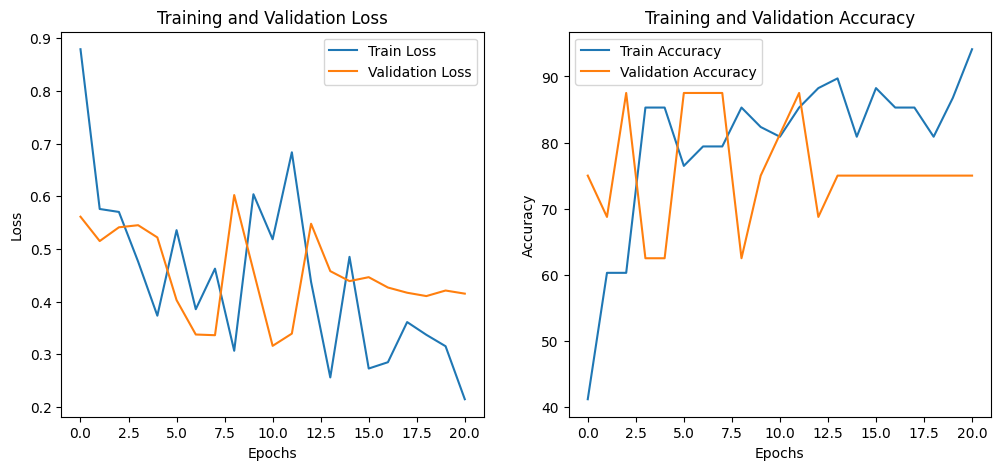

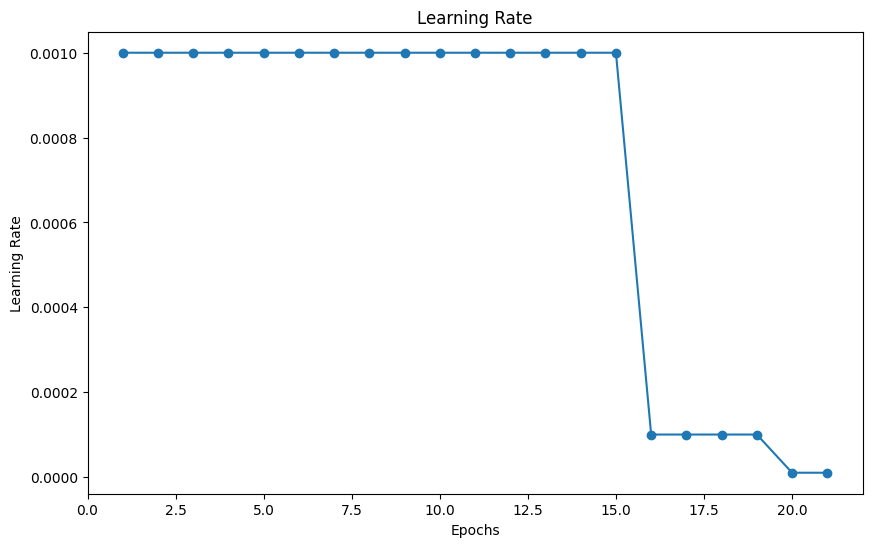

In [902]:
# plot loss and accuracy over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# plot accuracies over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

plt.figure(figsize=(10, 6))
plt.plot(range(1, last_epoch+1), learning_rates, marker='o', label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show();

In [903]:
checkpoint = torch.load("best_model.pth")

# load state dictionaries
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# print(model)

In [904]:
probabilities = predict(model, val_dataloader, device)[0]
predictions_val = torch.argmax(probabilities, dim=1)

print(predictions_val)

tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])


In [905]:
class_names = test_dataset.classes
predicted_classes = [class_names[idx] for idx in predictions_val]
print(predicted_classes[:50])

['Cancer', 'Non_Cancer', 'Cancer', 'Cancer', 'Non_Cancer', 'Non_Cancer', 'Non_Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Non_Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer']


Get Labels: 100%|██████████| 1/1 [00:00<00:00, 34.28it/s]


<Figure size 1000x800 with 0 Axes>

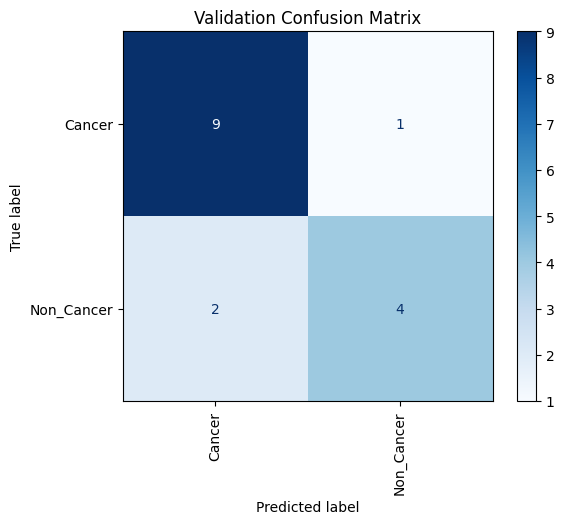

In [906]:

target_val = torch.cat([labels for _, labels in tqdm(val_dataloader, desc="Get Labels")])

cm = confusion_matrix(target_val.cpu(), predictions_val.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.dataset.classes)

plt.figure(figsize=(10,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical');
plt.title("Validation Confusion Matrix")
plt.show();

In [907]:
# Performance Insights on Validation dataset
y_true = target_val.cpu()
y_pred = predictions_val.cpu()

target_names = ['Cancer', 'Non_Cancer']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

      Cancer     0.8182    0.9000    0.8571        10
  Non_Cancer     0.8000    0.6667    0.7273         6

    accuracy                         0.8125        16
   macro avg     0.8091    0.7833    0.7922        16
weighted avg     0.8114    0.8125    0.8084        16



In [908]:
# now let's test our model test data(test_dataloader)
probabilities = predict(model, test_dataloader, device)[0]
predictions_test = torch.argmax(probabilities, dim=1)

counts = {int(label): int((predictions_test == label).sum()) for label in torch.unique(predictions_test)}
print(counts)

print(predictions_test)

{0: 95, 1: 109}
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])


In [909]:
class_names = test_dataset.classes
predicted_classes = [class_names[idx] for idx in predictions_test]
print(predicted_classes[:50])


['Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Non_Cancer', 'Non_Cancer', 'Cancer', 'Cancer', 'Cancer', 'Cancer', 'Non_Cancer', 'Non_Cancer', 'Non_Cancer', 'Cancer', 'Cancer', 'Non_Cancer', 'Cancer', 'Non_Cancer']


Get Labels: 100%|██████████| 7/7 [00:00<00:00, 17.96it/s]


<Figure size 1000x800 with 0 Axes>

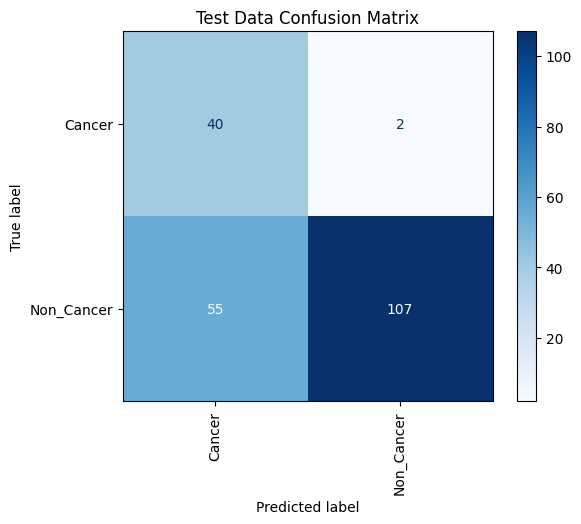

In [912]:
target_test = torch.cat([labels for _, labels in tqdm(test_dataloader, desc="Get Labels")])

cm = confusion_matrix(target_test.cpu(), predictions_test.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

plt.figure(figsize=(10,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical');
plt.title("Test Data Confusion Matrix")
plt.show();

In [911]:
from sklearn.metrics import classification_report

y_true = target_test.cpu()
y_pred = predictions_test.cpu()

target_names = ['Cancer', 'Non_Cancer']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

      Cancer     0.4211    0.9524    0.5839        42
  Non_Cancer     0.9817    0.6605    0.7897       162

    accuracy                         0.7206       204
   macro avg     0.7014    0.8064    0.6868       204
weighted avg     0.8662    0.7206    0.7473       204

